In [3]:
import pandas as pd
from utils import GetTrain, GetPrediction
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, SelectKBest, SelectPercentile
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
df = pd.read_csv('teams_matches_stats-2.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.sort_values(by = 'date', ignore_index = 'True', inplace = True)
y = list(map((lambda i: 1 if i == 'W' else 0), df['result']))
data = df.drop([ 'Opp Formation', 'Formation', 'Captain', 'Referee','result','time','game', 'day', 'season','GT', 'Gdiff'], axis = 1)

In [5]:
data

,Attendance,Performance.3,Standard.5,Poss,Standard.4,Standard.3,offside,crosses,fouls_drw,fouls_com,...,sec_yel,red,yellow,Standard.8,GA,GF,date,team,venue,opponent
0,31342,0.0,0.00,0.0,0.00,0.0,0,0,0,0,...,0,0,2,0,1,1,2017-07-26,Nice,Home,Ajax
1,21337,0.0,0.00,0.0,0.00,0.0,0,0,0,0,...,0,0,3,0,1,2,2017-07-27,Bordeaux,Home,Videoton
2,32124,0.0,0.00,0.0,0.00,0.0,0,0,0,0,...,0,0,0,0,0,1,2017-07-27,Everton,Home,Ružomberok
3,14000,0.0,0.00,0.0,0.00,0.0,0,0,0,0,...,0,0,1,0,0,1,2017-07-27,Freiburg,Home,NK Domžale
4,26783,0.0,0.00,0.0,0.00,0.0,0,0,0,0,...,0,0,1,0,1,1,2017-07-27,Athletic Club,Away,Dinamo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9740,0,66.7,0.29,40.0,0.14,50.0,4,7,14,7,...,0,1,2,0,1,2,2024-10-30,Eint Frankfurt,Home,Gladbach
9741,3041,100.0,0.33,72.0,0.15,46.2,4,22,5,14,...,0,0,2,0,0,4,2024-10-31,Espanyol,Away,San Tirso SD
9742,8724,66.7,0.50,60.0,0.24,48.0,8,23,4,13,...,0,0,3,0,1,6,2024-10-31,Betis,Away,CD Gévora
9743,0,0.0,0.44,77.0,0.23,53.3,3,22,11,10,...,0,0,0,0,0,7,2024-10-31,Las Palmas,Away,Ontiñena CF


In [6]:
enc = OneHotEncoder()

In [7]:
feat_data = GetTrain(data)
x = pd.DataFrame(feat_data, columns=data.drop(['team', 'date', 'opponent', 'venue'], axis=1).columns)
x = pd.concat([x, data['venue']], axis=1)

In [8]:
for_enc = x[['venue']]
enc = OneHotEncoder(handle_unknown='ignore',drop = 'first', sparse_output = False)
encd = enc.fit_transform(for_enc)
one_hot_df = pd.DataFrame(encd, columns=enc.get_feature_names_out(['venue']))
x = pd.concat([x.drop(['venue'], axis = 1),one_hot_df], axis = 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    train_size=0.8,
                                                    random_state=125)

In [10]:
normalizer = StandardScaler()
scaler = normalizer.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

Бейзлайн

In [11]:
#обучаю бейзлайн Random Forest на текущем датасете
clf = RandomForestClassifier(max_depth=8, random_state=42)
clf.fit(X_train_norm, y_train)

RandomForestClassifier(max_depth=8, random_state=42)

In [12]:
pred = clf.predict(X_test_norm)

In [13]:
f1_score(y_test,pred)

0.5914168136390359

In [14]:
feats = {}
for feature, importance in zip(X_train.columns, clf.feature_importances_):
    feats[feature] = importance

In [15]:
feats

{'Attendance': 0.04875383495105216,
 'Performance.3': 0.03175831449176202,
 'Standard.5': 0.02982770171204228,
 'Poss': 0.10140495665977785,
 'Standard.4': 0.028049053555679153,
 'Standard.3': 0.030055379365863565,
 'offside': 0.020983293161456907,
 'crosses': 0.03297991421130051,
 'fouls_drw': 0.025538704221772034,
 'fouls_com': 0.03230171779894016,
 'Int': 0.025979155396699496,
 'Tackles.1': 0.03342326316790506,
 'Standard.1': 0.05644816720455542,
 'Standard.2': 0.06872019564600243,
 'Performance.2': 0.022369284550519963,
 'Performance': 0.031680054836353576,
 'Performance.4': 0.023076780552765266,
 'OwnGoals': 0.006417471423768254,
 'Ast': 0.07037485946305862,
 'Penalty Kicks.1': 0.00884511743156314,
 'Penalty Kicks.2': 0.0052322554919945925,
 'Penalty Kicks.3': 0.003423835371531679,
 'Penalty Kicks': 0.009013529061883902,
 'Standard.9': 0.012756668094415623,
 'Tkl+Int': 0.03032439360603491,
 'sec_yel': 0.006374356960639526,
 'red': 0.009170631923986644,
 'yellow': 0.022221736333301

In [16]:
#буду перебирать игперпаарметры
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [17]:
grid_search.fit(X_train_norm, y_train)
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [18]:
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [19]:
y_pred = best_rf_model.predict(X_test_norm)
f1_score(y_test, y_pred)

0.5963890506697729

In [20]:
#выбираю лучшие признаки f_classif - глобально не вижу какого-то сильного улучшения
for i in range(30):
  sel = SelectKBest(score_func=f_classif, k=i+1)
  X_train_new = sel.fit_transform(X_train_norm, y_train)
  X_test_new = sel.transform(X_test_norm)
  clf2 = RandomForestClassifier(max_depth=10, random_state=42)
  clf2.fit(X_train_new, y_train)
  pred2 = clf2.predict(X_test_new)
  print(f'{i+1} : {f1_score(y_test,pred2)}')

1 : 0.5709156193895871
2 : 0.5761316872427984
3 : 0.5765550239234449
4 : 0.5697399527186762
5 : 0.5763111373011196
6 : 0.5762910798122066
7 : 0.5934195064629847
8 : 0.5957696827262045
9 : 0.5895478567234292
10 : 0.5823081429408319
11 : 0.5884413309982487
12 : 0.5941520467836258
13 : 0.5848502642395772
14 : 0.5887850467289719
15 : 0.5916813122437024
16 : 0.5924198250728863
17 : 0.5919811320754716
18 : 0.590882178804026
19 : 0.5894117647058823
20 : 0.5856807511737089
21 : 0.5821596244131455
22 : 0.5960419091967404
23 : 0.5982608695652174
24 : 0.59675550405562
25 : 0.604731679169071
26 : 0.6074332171893148
27 : 0.6005797101449275
28 : 0.5953488372093023
29 : 0.5988372093023255
30 : 0.5967365967365967


In [21]:
#а вот Лассо регуляризация показала эффект, пусть и несильный
sel = Lasso(alpha = 0.02)
sel_fit = sel.fit(X_train_norm, y_train)
coef = np.abs(sel_fit.coef_)
clf2 = RandomForestClassifier(max_depth=10, random_state=42)
clf2.fit(X_train_norm * coef, y_train)
pred2 = clf2.predict(X_test_norm*coef)
f1_score(y_test,pred2)

0.617579908675799

In [22]:
#получилось 8 признаков
coef

array([0.02740017, 0.        , 0.        , 0.05190575, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00500767, 0.        ,
       0.00685339, 0.01603895, 0.        , 0.01331826, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06060134, 0.04345423, 0.        ])

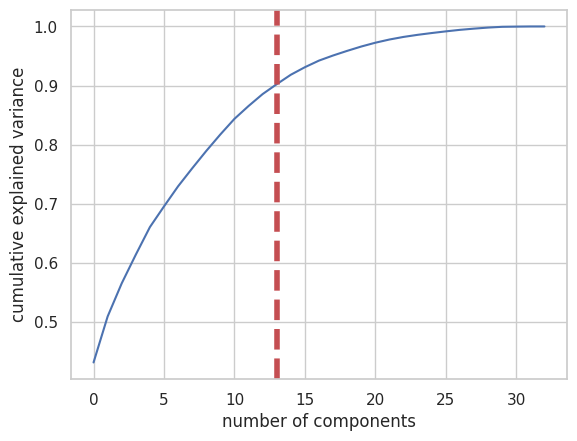

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.431417,0.431417
1,0.509184,0.077767
2,0.565342,0.056158
3,0.613885,0.048543
4,0.660496,0.046611
5,0.695485,0.034989
6,0.729521,0.034036
7,0.759896,0.030375
8,0.789357,0.029461
9,0.817280,0.027922


In [23]:
#теперь попробую PCA
pca_test = PCA(n_components=33)
pca_test.fit(X_train_norm)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=13, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(15))

In [24]:
pca = PCA(n_components=13)
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

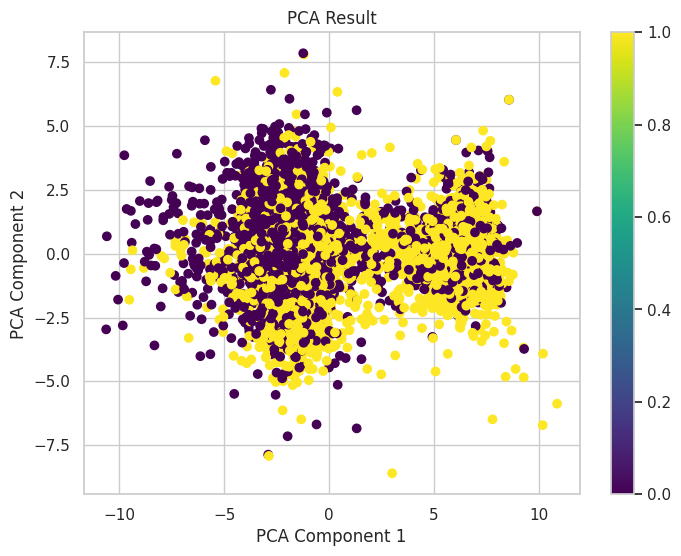

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Result')
plt.colorbar()
plt.show()

In [26]:
clf2 = RandomForestClassifier(max_depth=10, random_state=42)
clf2.fit(X_train_pca, y_train)
pred2 = clf2.predict(X_test_pca)
f1_score(y_test, pred2)

0.5908571428571429

Лассо регуляризация показала лучший результат из всех на текущем этапе

Feature Engineering: Полиномиальные признаки

In [35]:
poly = PolynomialFeatures(2)
X_train_plnm = poly.fit_transform(X_train_norm)

In [36]:
clf1 = RandomForestClassifier(max_depth=10, random_state=42)
clf1.fit(X_train_plnm, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [37]:
poly_test = PolynomialFeatures(2)
X_test_plnm = poly_test.fit_transform(X_test_norm)

In [38]:
pred1 = clf1.predict(X_test_plnm)

In [39]:
f1_score(y_test,pred1)

0.5893380199179847

In [40]:
#выбираю лучшие признаки f_classif - лучшее с признаком 12
for i in range(30):
  sel = SelectKBest(score_func=f_classif, k=i+1)
  X_train_new = sel.fit_transform(X_train_plnm, y_train)
  X_test_new = sel.transform(X_test_plnm)
  clf2 = RandomForestClassifier(max_depth=8, random_state=42)
  clf2.fit(X_train_new, y_train)
  pred2 = clf2.predict(X_test_new)
  print(f'{i+1} : {f1_score(y_test,pred2)}')

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


1 : 0.5726290516206483


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


2 : 0.5722784057108864


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


3 : 0.571773220747889


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


4 : 0.5736434108527132


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


5 : 0.5760286225402504


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


6 : 0.5806451612903226


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


7 : 0.5953927938570585


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


8 : 0.5913660555884093


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


9 : 0.5956444967628016


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


10 : 0.5908558030480656


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


11 : 0.5864306784660767


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


12 : 0.5897586815773985


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


13 : 0.5881656804733728


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


14 : 0.591283863368669


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


15 : 0.5894988066825776


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


16 : 0.5898345153664303


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


17 : 0.5921130076515597


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


18 : 0.5929411764705882


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


19 : 0.5872737886748395


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


20 : 0.582203889216264


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


21 : 0.591632292280495


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


22 : 0.5832349468713105


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


23 : 0.5771732702542874


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


24 : 0.5857395403653506


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


25 : 0.5922444183313749


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


26 : 0.5892018779342723


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


27 : 0.5862271924661565


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


28 : 0.5776986951364176


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


29 : 0.5860023724792408


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


30 : 0.58913813459268


In [ ]:
#выбираю лучшие признаки mutual_info_classif - ничего интересного не дает
for i in range(30):
  sel = SelectKBest(score_func=mutual_info_classif, k=i+1)
  X_train_new = sel.fit_transform(X_train_plnm, y_train)
  X_test_new = sel.transform(X_test_plnm)
  clf2 = RandomForestClassifier(max_depth=10, random_state=42)
  clf2.fit(X_train_new, y_train)
  pred2 = clf2.predict(X_test_new)
  print(f'{i+1} : {f1_score(y_test,pred2)}')

1 : 0.5684210526315789
2 : 0.549645390070922
3 : 0.5631067961165048
4 : 0.581518540317834
5 : 0.5840188014101058
6 : 0.5707491082045184
7 : 0.587347649448636
8 : 0.5845070422535211
9 : 0.5966337782936738
10 : 0.5773809523809523
11 : 0.5786090005844535
12 : 0.5892448512585813
13 : 0.5885780885780886
14 : 0.5835294117647059
15 : 0.5849056603773585
16 : 0.5903755868544601
17 : 0.5876168224299065
18 : 0.5855379188712522
19 : 0.580568720379147
20 : 0.5783274440518257
21 : 0.5795918367346938
22 : 0.5874043555032372
23 : 0.592463768115942
24 : 0.5858823529411765
25 : 0.5837264150943396
26 : 0.5928529584065613
27 : 0.5866510538641686
28 : 0.5829912023460411
29 : 0.5890570430733411
30 : 0.5813679245283019


In [ ]:
clf2 = RandomForestClassifier(max_depth=10, random_state=42)
clf2.fit(X_train_new, y_train)
pred2 = clf2.predict(X_test_new)
f1_score(y_test,pred2)

0.5885815185403178

In [52]:
#все еще хуже чем оригинальные признаки
sel = Lasso(alpha = 0.03)
sel_fit = sel.fit(X_train_plnm, y_train)
coef = np.abs(sel_fit.coef_)
clf2 = RandomForestClassifier(max_depth=10, random_state=42)
clf2.fit(X_train_plnm * coef, y_train)
pred2 = clf2.predict(X_test_plnm*coef)
f1_score(y_test,pred2)

0.6001154068090018

Использование компонент

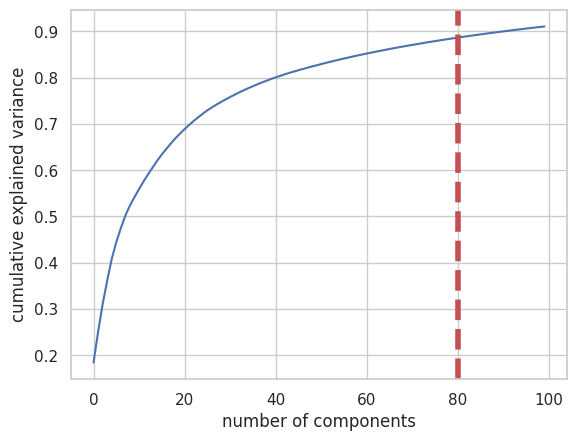

None

In [58]:
#PCA колво компонент - не вариант
pca_test = PCA(n_components=100)
pca_test.fit(X_train_plnm)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=80, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr

In [59]:
feats = {}
for feature, importance in zip(X_train.columns, clf2.feature_importances_):
    feats[feature] = importance

In [60]:
feats

{'Attendance': 0.0,
 'Performance.3': 0.1651359143199239,
 'Standard.5': 0.0,
 'Poss': 0.0,
 'Standard.4': 0.18981257161126933,
 'Standard.3': 0.0,
 'offside': 0.0,
 'crosses': 0.0,
 'fouls_drw': 0.0,
 'fouls_com': 0.0,
 'Int': 0.0,
 'Tackles.1': 0.0,
 'Standard.1': 0.0,
 'Standard.2': 0.0,
 'Performance.2': 0.15612923144856264,
 'Performance': 0.0,
 'Performance.4': 0.0,
 'OwnGoals': 0.1084298491690526,
 'Ast': 0.0,
 'Penalty Kicks.1': 0.15526947651888084,
 'Penalty Kicks.2': 0.0,
 'Penalty Kicks.3': 0.0,
 'Penalty Kicks': 0.0,
 'Standard.9': 0.0,
 'Tkl+Int': 0.0,
 'sec_yel': 0.0,
 'red': 0.0,
 'yellow': 0.0,
 'Standard.8': 0.0,
 'GA': 0.0,
 'GF': 0.0,
 'venue_Home': 0.16805093923571798,
 'venue_Neutral': 0.05017894728127266}

Теперь попробую после лассо регуляризации на изначальном датасете из оставшихся признаков сделать новые

In [68]:
sel = Lasso(alpha = 0.02)
sel_fit = sel.fit(X_train_norm, y_train)
coef = np.abs(sel_fit.coef_)
clf2 = RandomForestClassifier(max_depth=10, random_state=42)
clf2.fit(X_train_norm * coef, y_train)
pred2 = clf2.predict(X_test_norm*coef)
f1_score(y_test,pred2)

0.617579908675799

In [76]:
feats_final = {}
for feature, importance in zip(X_train.columns, clf2.feature_importances_):
    feats_final[feature] = importance

In [63]:
X_train_lasso = X_train_norm * coef
X_test_lasso = X_test_norm * coef

In [66]:
poly = PolynomialFeatures(2)
X_train_plnm2 = poly.fit_transform(X_train_lasso)
poly_test = PolynomialFeatures(2)
X_test_plnm2 = poly_test.fit_transform(X_test_lasso)

In [67]:
clf1 = RandomForestClassifier(max_depth=10, random_state=42)
clf1.fit(X_train_plnm2, y_train)
pred1 = clf1.predict(X_test_plnm2)
f1_score(y_test, pred1)

0.5959183673469388

ИТОГО:
Лучший f1 score в Random Forest - 0,62
При этом наилучшая комбинация - убрать признако с помощью Лассо регуляризации. Признаки, которые имеют значение:

In [77]:
feats_final

{'Attendance': 0.13961037207270513,
 'Performance.3': 0.0,
 'Standard.5': 0.0,
 'Poss': 0.18153515811047793,
 'Standard.4': 0.0,
 'Standard.3': 0.0,
 'offside': 0.0,
 'crosses': 0.0,
 'fouls_drw': 0.0,
 'fouls_com': 0.0,
 'Int': 0.0,
 'Tackles.1': 0.0,
 'Standard.1': 0.0,
 'Standard.2': 0.1474751656315579,
 'Performance.2': 0.0,
 'Performance': 0.10952041386781651,
 'Performance.4': 0.08536232059658715,
 'OwnGoals': 0.0,
 'Ast': 0.14057069005231387,
 'Penalty Kicks.1': 0.0,
 'Penalty Kicks.2': 0.0,
 'Penalty Kicks.3': 0.0,
 'Penalty Kicks': 0.0,
 'Standard.9': 0.0,
 'Tkl+Int': 0.0,
 'sec_yel': 0.0,
 'red': 0.0,
 'yellow': 0.0,
 'Standard.8': 0.0,
 'GA': 0.0,
 'GF': 0.14820613551342157,
 'venue_Home': 0.04771974415512001,
 'venue_Neutral': 0.0}